# 3W - Strategy Thinking project

In [1]:
# IMPORTS AND CONFIGURATIONS

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

import glob
import os
import time

from sklearn.dummy import DummyClassifier
import sklearn.metrics as metrics

# importing classes and functions for PCA, hyperparametrisation and cross-validation
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score



## Data Preparation

Preprocessing a dataset through data characterisation involves summarising the features and characteristics present in the data using statistical measures and visualisations techniques such as bar charts and scatter plots. After this stage, it should be possible to identify biases, patterns, trends, and any missing or irrelevant data in the data set that may need to be addressed.

This dataset is composed by instances of eight types of undesirable events characterized by eight process variables from three different sources: real instances, simulated instances and hand-drawn instances. All real instances were taken from the plant information system that is used to monitor the industrial processes at an operational unit in Brazilian state of Espírito Santo. The simulated instances were all generated using OLGA ([Schlumberger](https://www.software.slb.com/products/olga)), a dynamic multiphase flow simulator that is widely used by oil companies worldwide (Andreolli, 2016). Finally, the hand-drawn instances were generated by a specific tool developed by Petrobras researchers for this dataset to incorporate undesirable events classfied as rare. 
 
### Data Characterisation
The data consists of over 50 million observations, with 13 columns of data for each observation. The first column, `label`, indicates the event type for each observation. The second column, `well`, contains the name of the well the observation was taken from. Hand-drawn and simulated instances have fixed names for in this column, while real instances have names masked with incremental id. The third column, `id`, is an identifier for the observation and it is incremental for hand-drawn and simulated instances, while each real instance has an id generated from its first timestamp. The columns representing the process variables are:

* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG) - installed on Christmas Tree;
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT) - installed on Christmas Tree;
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP) - located on platform;
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;

The pressure features are measured in Pascal (Pa), the volumetric flow rate features are measured in standard cubic meters per second (SCM/s), and the temperature features are measured in degrees Celsius (°C).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type) - target variable;
* **well**: well name. Hand-drawn and simulated instances have fixed names (respectively, `drawn` and `simulated`. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp;
* **class**: Although it can be used to identify periods of normal operation, fault transients, and faulty steady states, which can help with diagnosis and maintenance, it is a category which results from label, which is our target here

The labels are:
* 0 - Normal Operation = `Normal`
* 1 - Abrupt Increase of BSW = `AbrIncrBSW`
* 2 - Spurious Closure of DHSV = `SpurClosDHSW`
* 3 - Severe Slugging = `SevSlug`
* 4 - Flow Instability = `FlowInst`
* 5 - Rapid Productivity Loss = `RProdLoss`
* 6 - Quick Restriction in PCK	= `QuiRestrPCK`
* 7 - Scaling in PCK = `ScalingPCK`
* 8 - Hydrate in Production Line = `HydrProdLine`

More information about these variables can be obtained from the following publicly available documents:

* ***Option in Portuguese***: R.E.V. Vargas. Base de dados e benchmarks para prognóstico de anomalias em sistemas de elevação de petróleo. Universidade Federal do Espírito Santo. Doctoral thesis. 2019. https://github.com/petrobras/3W/raw/master/docs/doctoral_thesis_ricardo_vargas.pdf.
* ***Option in English***: B.G. Carvalho. Evaluating machine learning techniques for detection of flow instability events in offshore oil wells. Universidade Federal do Espírito Santo. Master's degree dissertation. 2021. https://github.com/petrobras/3W/raw/master/docs/master_degree_dissertation_bruno_carvalho.pdf.

In order to maintain the realistic aspects of the data, the dataset was extracted without preprocessing, including the presence of `NaN` values, frozen variables due to sensor or communication issues, instances with varying sizes, and outliers (R.E.V. Vargas, et al. 2019). 

From all 50,822,124 entries, 3,086,851 are duplicated, that is, approximately 6.07% of total. These duplicated rows may be related to frozen variables from real instances, as simulated and hand-drawn instances are naturally free of such problems. Although no missing values were found for columns `label`, `well`, and `id`, other features presented null or absent values. Notably, the column `T-JUS-CKGL` turned out to be completely empty.

In [2]:
df = pd.read_csv('3Wdataset_real.csv', index_col=None, parse_dates=['timestamp'])

# only using real, since simulated and drawn doesnt have QGL and P-JUS-CKGL
# df_real.info()

# df_drawn = pd.read_csv('3Wdataset_drawn.csv', index_col=None)
# # df_drawn.info()

# df_sim1 = pd.read_csv('3Wdataset_simulated_1of2.csv', index_col=None)
# # df_sim1.info()

# df_sim2 = pd.read_csv('3Wdataset_simulated_2of2.csv', index_col=None)
# # df_sim2.info()

# df = pd.concat([
#     df_real,
#     df_sim1,
#     df_sim2,
#     df_drawn
# ])

# df = df.drop('source', axis=1)

# dismissing temporary DFs to release memory
# del df_sim1
# del df_sim2
# del df_real
# del df_drawn

df.shape

(13952911, 14)

### Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13952911 entries, 0 to 13952910
Data columns (total 14 columns):
 #   Column      Dtype         
---  ------      -----         
 0   timestamp   datetime64[ns]
 1   label       int64         
 2   well        object        
 3   id          int64         
 4   P-PDG       float64       
 5   P-TPT       float64       
 6   T-TPT       float64       
 7   P-MON-CKP   float64       
 8   T-JUS-CKP   float64       
 9   P-JUS-CKGL  float64       
 10  T-JUS-CKGL  float64       
 11  QGL         float64       
 12  class       float64       
 13  source      object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 1.5+ GB


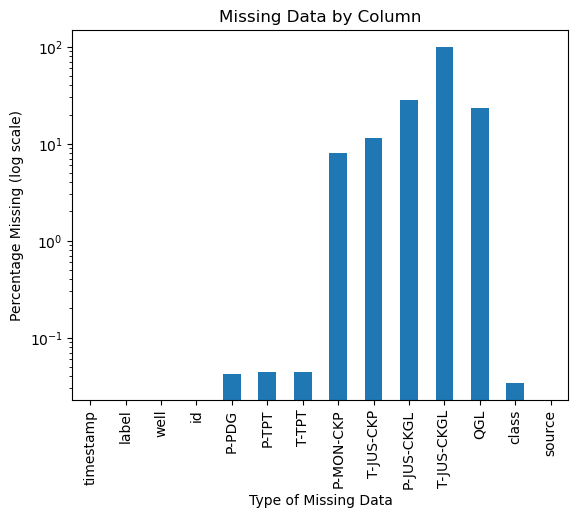

In [4]:
# Finding missing values
missing = df.isnull()
missing.sum()

total_missing = df.isnull().sum()
percent_missing = total_missing * 100 / len(df)
missing_value_df = pd.DataFrame({'percent': percent_missing, 'total':total_missing})

# Transpose the DataFrame
missing_value_df.T.head()

# # Plot the bar chart
missing_value_df['percent'].plot.bar()

# Plot the bar chart
ax = missing_value_df['percent'].plot.bar()

# Add labels and title
ax.set_xlabel('Type of Missing Data')
ax.set_ylabel('Percentage Missing (log scale)')
ax.set_title('Missing Data by Column')

# Use log scale for y-axis
plt.yscale('log')

plt.show()

In [5]:
df.head()

,timestamp,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class,source
0,2017-06-25 22:01:27,0,WELL-00002,20170625220127,0.0,8698015.0,117.6015,2142158.0,75.63453,2310426.0,NaN,0.0,0.0,real
1,2017-06-25 22:01:28,0,WELL-00002,20170625220127,0.0,8698015.0,117.6014,2172395.0,75.65491,2310427.0,NaN,0.0,0.0,real
2,2017-06-25 22:01:29,0,WELL-00002,20170625220127,0.0,8698015.0,117.6013,2202631.0,75.67529,2310427.0,NaN,0.0,0.0,real
3,2017-06-25 22:01:30,0,WELL-00002,20170625220127,0.0,8698015.0,117.6012,2180472.0,75.69567,2310427.0,NaN,0.0,0.0,real
4,2017-06-25 22:01:31,0,WELL-00002,20170625220127,0.0,8698015.0,117.6011,2158313.0,75.71606,2310428.0,NaN,0.0,0.0,real


### Data Cleaning

In [6]:
# drop rows with missing or null class column
df_clean = df.dropna(subset=['P-PDG','P-TPT','T-JUS-CKP','P-MON-CKP','T-TPT','P-MON-CKP','QGL','P-JUS-CKGL'])

# first interaction will dismiss timestamp in order to remove duplicates, even if it overlooks frozen
# variables due to sensor or communication issues

# removing class, since it results from label
# removing ID from df

df_clean = df_clean.drop([
#     'timestamp', 
    'class',
    'T-JUS-CKGL', # T-JUS-CKGL is empty
    'id', 
    'source'
], axis=1)

# checking duplicated rows after removing timestamp and ids
df_clean = df_clean.drop_duplicates()

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10007275 entries, 0 to 13952910
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   timestamp   datetime64[ns]
 1   label       int64         
 2   well        object        
 3   P-PDG       float64       
 4   P-TPT       float64       
 5   T-TPT       float64       
 6   P-MON-CKP   float64       
 7   T-JUS-CKP   float64       
 8   P-JUS-CKGL  float64       
 9   QGL         float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 839.8+ MB


In [9]:
# Finding missing values
missing = df_clean.isnull()
missing.sum()

total_missing = df_clean.isnull().sum()
percent_missing = total_missing * 100 / len(df_clean)
missing_value_df = pd.DataFrame({'percent': percent_missing, 'total':total_missing})

# Total of Missing Values
missing_value_df

,percent,total
timestamp,0.0,0
label,0.0,0
well,0.0,0
P-PDG,0.0,0
P-TPT,0.0,0
T-TPT,0.0,0
P-MON-CKP,0.0,0
T-JUS-CKP,0.0,0
P-JUS-CKGL,0.0,0
QGL,0.0,0


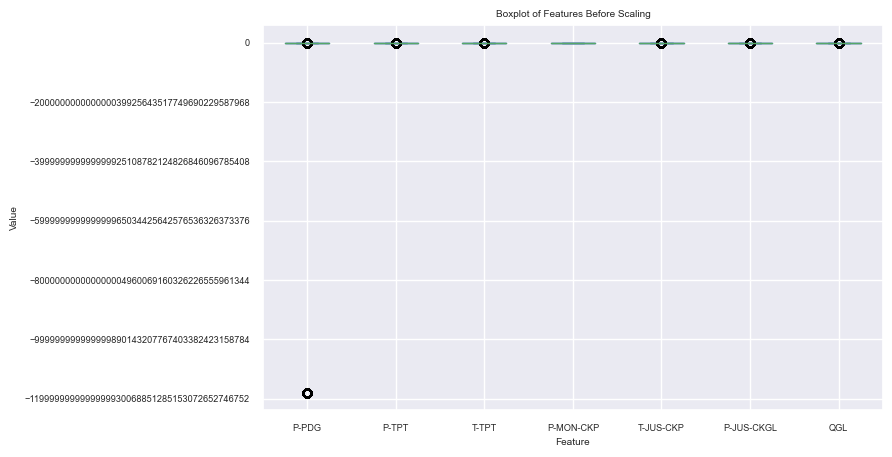

In [102]:
# Before Scaling

df_clean.plot(kind='box', figsize=(8, 5))
plt.title('Boxplot of Features Before Scaling')
plt.xlabel('Feature')
plt.ylabel('Value')
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.show()

### Feature Engineering

In [10]:
dt_feat = df_clean

# Change 'label' column to object dtype
dt_feat['label'] = dt_feat['label'].astype('object') 

# Create boolean columns for each label
label_dummies = pd.get_dummies(dt_feat['label'], prefix='label')
dt_feat = pd.concat([dt_feat, label_dummies], axis=1)

# Rename boolean columns
column_names = {
    'label_0': 'Normal',
    'label_1': 'AbrIncrBSW',
    'label_2': 'SpurClosDHSW',
    'label_3': 'SevSlug',
    'label_4': 'FlowInst',
    'label_5': 'RProdLoss',
    'label_6': 'QuiRestrPCK',
    'label_7': 'ScalingPCK',
    'label_8': 'HydrProdLine'
}
dt_feat = dt_feat.rename(columns=column_names)

# Drop the original 'label' column and Normal column, since all other events must be 0
dt_feat = dt_feat.drop(['label','Normal'], axis=1)

dt_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10007275 entries, 0 to 13952910
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   timestamp     datetime64[ns]
 1   well          object        
 2   P-PDG         float64       
 3   P-TPT         float64       
 4   T-TPT         float64       
 5   P-MON-CKP     float64       
 6   T-JUS-CKP     float64       
 7   P-JUS-CKGL    float64       
 8   QGL           float64       
 9   AbrIncrBSW    uint8         
 10  SpurClosDHSW  uint8         
 11  SevSlug       uint8         
 12  FlowInst      uint8         
 13  RProdLoss     uint8         
 14  QuiRestrPCK   uint8         
 15  ScalingPCK    uint8         
dtypes: datetime64[ns](1), float64(7), object(1), uint8(7)
memory usage: 830.3+ MB


In [12]:
dt_feat_target = dt_feat.drop([
    'AbrIncrBSW',
    'SpurClosDHSW',
#     'SevSlug',
    'FlowInst',
    'RProdLoss',
    'QuiRestrPCK',
    'ScalingPCK'
#     ,'HydrProdLine'
], axis=1)

dt_feat_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10007275 entries, 0 to 13952910
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   timestamp   datetime64[ns]
 1   well        object        
 2   P-PDG       float64       
 3   P-TPT       float64       
 4   T-TPT       float64       
 5   P-MON-CKP   float64       
 6   T-JUS-CKP   float64       
 7   P-JUS-CKGL  float64       
 8   QGL         float64       
 9   SevSlug     uint8         
dtypes: datetime64[ns](1), float64(7), object(1), uint8(1)
memory usage: 773.0+ MB


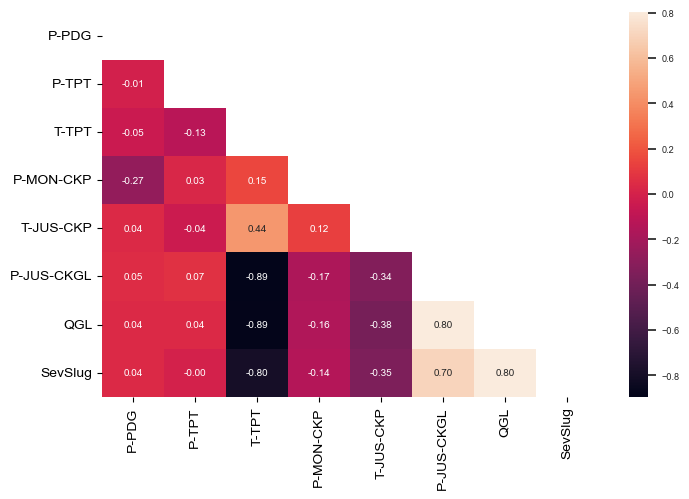

In [13]:
# Computing the correlations
corr = dt_feat_target.corr()

# Creating a boolean mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plotting the heatmap with the mask
fig, ax = plt.subplots(figsize=(8, 5))
sns.set(font_scale=0.6)
sns.heatmap(corr, annot=True, mask=mask, ax=ax, fmt='.2f')
plt.show()

### Handling Imbalanced Data

In [14]:
# defining features (X) and label (y)

target = 'SevSlug'

X = dt_feat_target.drop([target,'timestamp','well'], axis=1)
y = dt_feat_target['SevSlug']

# splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# calculating the percentage of each label in the dataset
y_train.value_counts(normalize=True)

0    0.943194
1    0.056806
Name: SevSlug, dtype: float64

In [15]:
# establishing a baseline with a DummyClassifier
dummyc = DummyClassifier()
dummyc.fit(X_train, y_train)

# retrieving score for DummyClassifier
score = dummyc.score(X_train, y_train)
y_predicted = dummyc.predict(X_test)

print("Score: ", score)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted))

Score:  0.9431939514003562
Accuracy:  0.9432547821459888


In [16]:
X.isna().sum().sum()

0

In [17]:
X.shape

(10007275, 7)

In [18]:
# balancing data 
balancing = RandomUnderSampler(random_state=42)
# balancing = SMOTE(random_state=42)
# balancing = SMOTETomek(random_state=42)

X_resampled, y_resampled = balancing.fit_resample(X, y)

In [19]:
X_resampled.isna().sum().sum()

0

In [20]:
X_resampled.shape

(1136704, 7)

In [21]:
# Finding missing values
missing = X_resampled.isnull()
missing.sum()

total_missing = X_resampled.isnull().sum()
percent_missing = total_missing * 100 / len(X_resampled)
missing_value_df = pd.DataFrame({'percent': percent_missing, 'total':total_missing})

missing_value_df.T

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0
total,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# splitting the balanced datasets for training and test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# calculating the percentage of each label in the dataset after undersampling
y_train.value_counts(normalize=True)

0    0.500125
1    0.499875
Name: SevSlug, dtype: float64

### Data Scaling

In [31]:
X_train.isna().sum()

P-PDG         0
P-TPT         0
T-TPT         0
P-MON-CKP     0
T-JUS-CKP     0
P-JUS-CKGL    0
QGL           0
dtype: int64

In [34]:
# Scale the pressure and temperature DataFrames separately
scaler = StandardScaler()
X_train_scaled_data = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled_data, columns=X_train.columns)

X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909363 entries, 0 to 909362
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   P-PDG       909363 non-null  float64
 1   P-TPT       909363 non-null  float64
 2   T-TPT       909363 non-null  float64
 3   P-MON-CKP   909363 non-null  float64
 4   T-JUS-CKP   909363 non-null  float64
 5   P-JUS-CKGL  909363 non-null  float64
 6   QGL         909363 non-null  float64
dtypes: float64(7)
memory usage: 48.6 MB


In [57]:
# normalising test features
X_test_scaled_data = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled_data, columns=X_test.columns)
X_test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227341 entries, 0 to 227340
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   P-PDG       227341 non-null  float64
 1   P-TPT       227341 non-null  float64
 2   T-TPT       227341 non-null  float64
 3   P-MON-CKP   227341 non-null  float64
 4   T-JUS-CKP   227341 non-null  float64
 5   P-JUS-CKGL  227341 non-null  float64
 6   QGL         227341 non-null  float64
dtypes: float64(7)
memory usage: 12.1 MB


In [35]:
X_train_scaled.isna().sum()

P-PDG         0
P-TPT         0
T-TPT         0
P-MON-CKP     0
T-JUS-CKP     0
P-JUS-CKGL    0
QGL           0
dtype: int64

In [36]:
X_train.shape

(909363, 7)

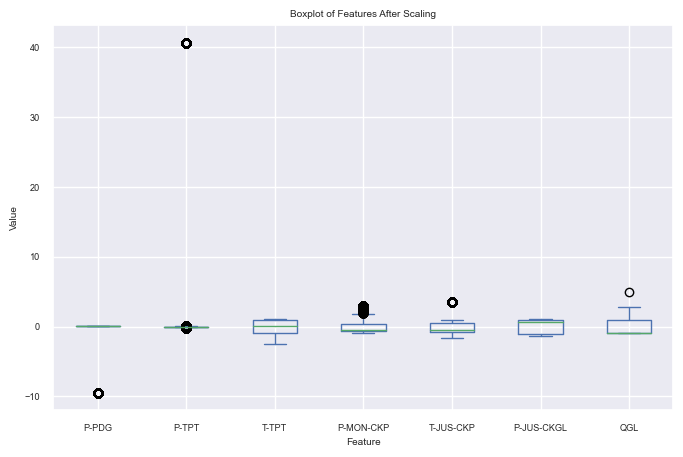

In [54]:
# After Scaling

X_train_scaled.plot(kind='box', figsize=(8, 5))
plt.title('Boxplot of Features After Scaling')
plt.xlabel('Feature')
plt.ylabel('Value')
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.show()

## Dimensionality Reduction

In [46]:
# initialising PCA with 2 components
pca = PCA(n_components=2)

# fitting PCA with features after undersampling and normalisation
pca.fit(X_train_scaled)

# reducing dimensionality in undersampled, normalised training dataset
X_train_pca = pca.transform(X_train_scaled)

print("Original shape: {}".format(str(X_train_scaled.shape)))
print("Reduced shape: {}".format(str(X_train_pca.shape)))

Original shape: (909363, 7)
Reduced shape: (909363, 2)


In [47]:
# retrieving variance captured by the components
variance_captured = pca.explained_variance_ratio_
print(variance_captured)

[0.53503201 0.16077671]


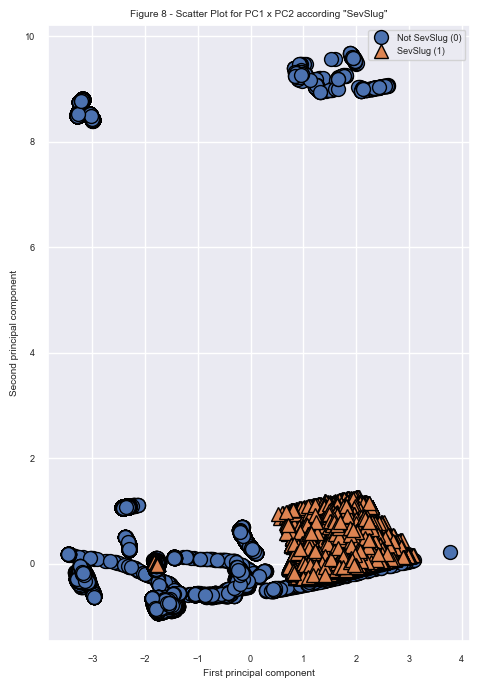

In [49]:
import mglearn

# plotting first vs. second principal component, colored by class
plt.figure(figsize = (8, 8))

# selecting PC1, PC2, then label
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train)

plt.legend(['Not SevSlug (0)','SevSlug (1)'], loc="best")
plt.gca().set_aspect("equal")
plt.title('Figure 8 - Scatter Plot for PC1 x PC2 according "SevSlug"')
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

Text(0, 0.5, 'Principal components')

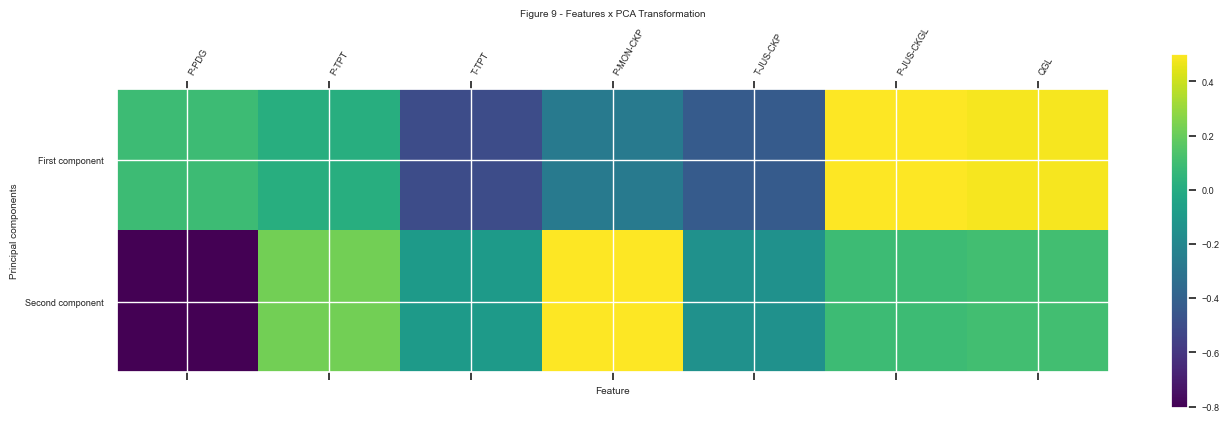

In [50]:
# creating a matrix representing the directions of maximum variance in the data
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(list(X_train_scaled.columns))), list(X_train_scaled.columns), rotation=60, ha='left')
plt.title('Figure 9 - Features x PCA Transformation')
plt.xlabel("Feature")
plt.ylabel("Principal components")

## Machine Learning

In [58]:
# initialising PCA for test data, with 2 components
pca_test = PCA(n_components=2)

# fitting PCA with test features after normalisation
pca_test.fit(X_test_scaled)

# reducing dimensionality in normalised test dataset
X_test_pca = pca.transform(X_test_scaled)

print("Original shape: {}".format(str(X_test_scaled.shape)))
print("Reduced shape: {}".format(str(X_test_pca.shape)))

Original shape: (227341, 7)
Reduced shape: (227341, 2)


In [62]:
# DummyClassifier x Normalised data
dummyc = DummyClassifier()
dummyc.fit(X_train_pca, y_train)

# confirming if score for Dummy classifier results from a balanced dataset
score = dummyc.score(X_train_pca, y_train)
y_predicted = dummyc.predict(X_test_pca)

print("Score: ", score)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted))

Score:  0.5001248126435758
Accuracy:  0.4995007499747076


### Linear SVC

#### Hyperparameter optimisation

In [67]:
start_time = time.time()
print("Start time:", time.ctime(start_time))

from sklearn.svm import LinearSVC

# Dict containing different parameters for LinearSVC 
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty':['l1', 'l2'],
    'dual': [False, True]
}

# LinearSVC classifier
lin_clf = LinearSVC()

# GridSearchCV object is instantiated with these parameters and fit to training data
grid_search_lsvc = GridSearchCV(estimator=lin_clf, param_grid=param_grid, verbose=1)

# GridSearchCV object will be used to find the optimal combination of these parameters for the classification model
grid_search_lsvc.fit(X_train_pca, y_train)

end_time = time.time()
print("End time:", time.ctime(end_time))

Start time: Sun Apr  2 09:47:19 2023
Fitting 5 folds for each of 28 candidates, totalling 140 fits
End time: Sun Apr  2 10:35:05 2023


In [68]:
# best accuracy achieved in the grid search and the best estimator
print("best accuracy", grid_search_lsvc.best_score_)
print(grid_search_lsvc.best_estimator_)

best accuracy 0.9715031297577944
LinearSVC(C=0.0001, dual=False, penalty='l1')


In [71]:
# retrieving optimal values for the parameters dual, loss, multi_class, and penalty from grid search
optimal_dual = grid_search_lsvc.best_params_['dual']
# optimal_loss = grid_search_lsvc.best_params_['loss']
optimal_c = grid_search_lsvc.best_params_['C']
optimal_penalty = grid_search_lsvc.best_params_['penalty']

# instantiating a new LinearSVC classifier with optimal values
lin_clf = LinearSVC(dual=optimal_dual, C=optimal_c, penalty=optimal_penalty)
lin_clf.fit(X_train_pca, y_train)

# calculating score and accuracy
score = lin_clf.score(X_train_pca, y_train)
y_predicted_lin_clf = lin_clf.predict(X_test_pca)

print("Score: ", score)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted_lin_clf))

os.system('say "Victor, the Hyperparameters for Linear SVC were successfully found."')

Score:  0.9715603119986188
Accuracy:  0.9716857056140336


### SGD Classifier

#### Hyperparameter optimisation

In [94]:
start_time = time.time()
print("Start time:", time.ctime(start_time))

from sklearn.linear_model import SGDClassifier

# defining parameter grid for grid search
param_grid = {
    'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
}

# instantiating SGD classifier
SGD = SGDClassifier()

# setting up grid search with SGD classifier and param_grid
grid_search_sgd = GridSearchCV(estimator=SGD, param_grid=param_grid, verbose=1)

# fitting grid search to training data
grid_search_sgd.fit(X_train_pca, y_train)

end_time = time.time()
print("End time:", time.ctime(end_time))
os.system('say "Victor, the Hyperparameters for SGD classifier were successfully found."')

Start time: Sun Apr  2 22:43:35 2023
Fitting 5 folds for each of 10 candidates, totalling 50 fits
End time: Sun Apr  2 22:44:04 2023


0

In [95]:
# best accuracy achieved in the grid search and the best estimator.
print("best accuracy", grid_search_sgd.best_score_)
print(grid_search_sgd.best_estimator_)

best accuracy 0.97371566761297
SGDClassifier(max_iter=1)


In [96]:
optimal_max_iter = grid_search_sgd.best_params_['max_iter']
# optimal_weights = grid_search_knn.best_params_['weights']
# optimal_p = grid_search_knn.best_params_['p']

# a new KNeighborsClassifier object created and fitted with the training data
SGD = SGDClassifier(max_iter=optimal_max_iter)
SGD.fit(X_train_pca, y_train)

# calculating score and accuracy
score = SGD.score(X_train_pca, y_train)
y_predicted_sgd = SGD.predict(X_test_pca)

print("Score: ", score)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted_sgd))

Score:  0.9722882941135718
Accuracy:  0.972358703445485


### k-Nearest Neighbours

#### Hyperparameter optimisation

In [75]:
start_time = time.time()
print("Start time:", time.ctime(start_time))

from sklearn.neighbors import KNeighborsClassifier

# defining parameter grid for grid search
param_grid = {
    'n_neighbors': range(3, 218, 5)
#     'weights': ['uniform','distance']
#     'p': range(1, 11, 5)
}

# instantiating kNN classifier
kNN = KNeighborsClassifier()

# setting up grid search with kNN classifier and param_grid
grid_search_knn = GridSearchCV(estimator=kNN, param_grid=param_grid, verbose=1)

# fitting grid search to training data
grid_search_knn.fit(X_train_pca, y_train)

end_time = time.time()
print("End time:", time.ctime(end_time))

os.system('say "Victor, the Hyperparameters for kNN were successfully found."')

Start time: Sun Apr  2 10:44:46 2023
Fitting 5 folds for each of 43 candidates, totalling 215 fits
End time: Sun Apr  2 11:21:24 2023


In [76]:
# best accuracy achieved in the grid search and the best estimator.
print("best accuracy", grid_search_knn.best_score_)
print(grid_search_knn.best_estimator_)

best accuracy 0.981654191204059
KNeighborsClassifier(n_neighbors=13)


In [77]:
# modeling after optimal k ("sweet spot") and weights values were determined
optimal_k = grid_search_knn.best_params_['n_neighbors']
# optimal_weights = grid_search_knn.best_params_['weights']
# optimal_p = grid_search_knn.best_params_['p']

# a new KNeighborsClassifier object created and fitted with the training data
kNN = KNeighborsClassifier(n_neighbors=optimal_k)
kNN.fit(X_train_pca, y_train)

# calculating score and accuracy
score = kNN.score(X_train_pca, y_train)
y_predicted_knn = kNN.predict(X_test_pca)

print("Score: ", score)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted_knn))

Score:  0.9833311889751397
Accuracy:  0.9749231330908196


In [78]:
start_time = time.time()
print("Start time:", time.ctime(start_time))

# initialising arrays for storing train and test accuracy
neighbors = np.arange(3, 218, 5)     
train_accuracy = np.zeros(len(neighbors))    
test_accuracy = np.zeros(len(neighbors))    

# looping over different values of k
for i, k in enumerate(neighbors):                         
    kNN = KNeighborsClassifier(n_neighbors=k)           
    kNN.fit(X_train_pca, y_train)                             
    train_accuracy[i] = kNN.score(X_train_pca, y_train)       
    test_accuracy[i] = kNN.score(X_test_pca, y_test)  
    
end_time = time.time()
print("End time:", time.ctime(end_time))

Start time: Sun Apr  2 11:26:38 2023
End time: Sun Apr  2 15:18:57 2023


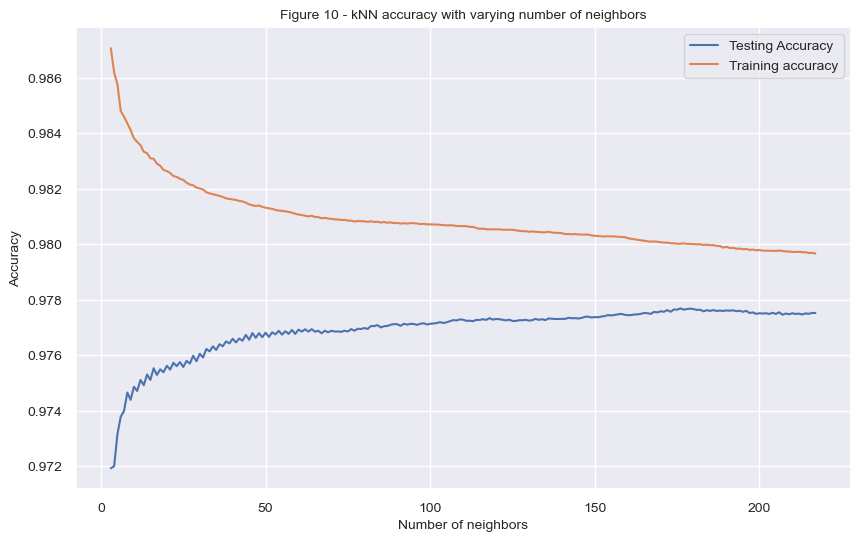

In [79]:
# creating figure, adding title
plt.figure(figsize = (10, 6))
plt.title('Figure 10 - kNN accuracy with varying number of neighbors', fontsize = 10)

# plotting the test accuracy and traning accuracy x number of neighbours
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training accuracy')

# adding legend, axes labels, setting font size and axes ticks
plt.legend(prop={'size': 10})
plt.xlabel('Number of neighbors', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

## Conclusion

### Classification Report

In [97]:
# generating a classification report for LinearSVC
cr_linearsvc = metrics.classification_report(y_test, y_predicted_lin_clf, digits=4)

# generating a classification report for SGD
cr_sgd = metrics.classification_report(y_test, y_predicted_sgd, digits=4)

# generating a classification report for kNN
cr_knn = metrics.classification_report(y_test, y_predicted_knn, digits=4)

#### Linear SVC

In [81]:
# printing classification report for LinearSVC
print(cr_linearsvc)

              precision    recall  f1-score   support

           0     0.9683    0.9753    0.9718    113557
           1     0.9751    0.9681    0.9716    113784

    accuracy                         0.9717    227341
   macro avg     0.9717    0.9717    0.9717    227341
weighted avg     0.9717    0.9717    0.9717    227341



#### SGD Classifier

In [98]:
# printing classification report for SGD
print(cr_sgd)

              precision    recall  f1-score   support

           0     0.9683    0.9766    0.9724    113557
           1     0.9765    0.9681    0.9723    113784

    accuracy                         0.9724    227341
   macro avg     0.9724    0.9724    0.9724    227341
weighted avg     0.9724    0.9724    0.9724    227341



#### k-Neighbours Classifier

In [82]:
# printing classification report for kNN classifier
print(cr_knn)

              precision    recall  f1-score   support

           0     0.9766    0.9731    0.9749    113557
           1     0.9733    0.9767    0.9750    113784

    accuracy                         0.9749    227341
   macro avg     0.9749    0.9749    0.9749    227341
weighted avg     0.9749    0.9749    0.9749    227341



### Confusion Matrix

In [83]:
# setting labels valid for all following confusion matrices
cm_labels = ['No Sev Slug (0)', 'Sev Slug (1)']

#### Linear SVC

<AxesSubplot:>

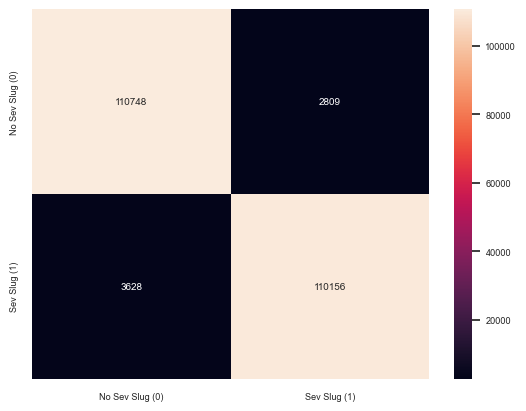

In [84]:
# generating confusion matrix using the test labels and the predicted labels from LinearSVC classifier
cm = metrics.confusion_matrix(y_test, y_predicted_lin_clf)

# converting the confusion matrix into a pandas dataframe
cm_dataframe = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)

# creating a heatmap using using seaborn
sns.heatmap(cm_dataframe, annot=True, fmt='d')

#### SGD Classifier

<AxesSubplot:>

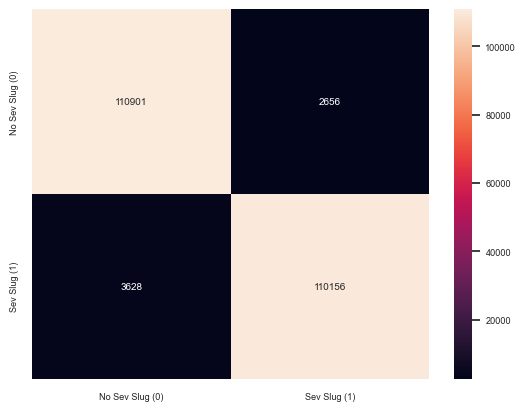

In [99]:
# generating confusion matrix using the test labels and the predicted labels from LinearSVC classifier
cm = metrics.confusion_matrix(y_test, y_predicted_sgd)

# converting the confusion matrix into a pandas dataframe
cm_dataframe = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)

# creating a heatmap using using seaborn
sns.heatmap(cm_dataframe, annot=True, fmt='d')

#### k-Neighbours Classifier

<AxesSubplot:>

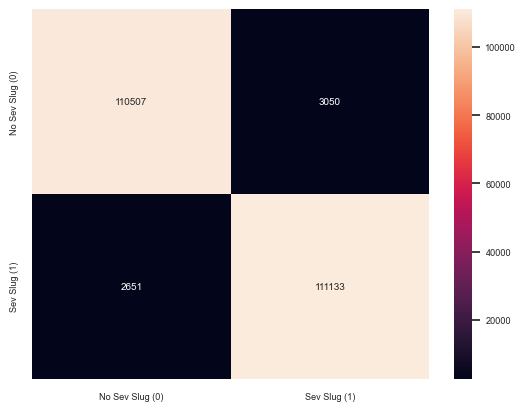

In [85]:
# generating confusion matrix using the test labels and the predicted labels from kNeighbour Classifier
cm = metrics.confusion_matrix(y_test, y_predicted_knn)

# converting the confusion matrix into a pandas dataframe
cm_dataframe = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)

# creating a heatmap using using seaborn
sns.heatmap(cm_dataframe, annot=True, fmt='d')

### Cross Validation

In [86]:
# generating a 10-fold cross-validation for LinearSVC
scores = cross_val_score(lin_clf, X_train_pca, y_train, cv=10)

print(f"Mean score: {np.mean(scores):.3f}")
print(f"Standard deviation: {np.std(scores):.3f}")

Mean score: 0.972
Standard deviation: 0.000


In [101]:
# generating a 10-fold cross-validation for SGD
scores = cross_val_score(SGD, X_train_pca, y_train, cv=10)

print(f"Mean score: {np.mean(scores):.3f}")
print(f"Standard deviation: {np.std(scores):.3f}")

Mean score: 0.973
Standard deviation: 0.001


In [87]:
# generating a 10-fold cross validation for kNN
scores = cross_val_score(kNN, X_train_pca, y_train, cv=10)

print(f"Mean score: {np.mean(scores):.3f}")
print(f"Standard deviation: {np.std(scores):.3f}")

Mean score: 0.979
Standard deviation: 0.000


Ideas:
* study basic time series analysis and consider frozen variables